In [ ]:
!git clone https://github.com/antares511/instance-map.git

Cloning into 'instance-map'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 157 (delta 13), reused 150 (delta 11), pack-reused 0
Receiving objects: 100% (157/157), 22.88 MiB | 26.93 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
#Grounding DINO and SAM requirements.txt install
%cd ~/instance-map
!pip install -q -r requirements.txt
%cd ~/instance-map/GroundingDINO
!pip install -q .
%cd ~/instance-map/segment_anything
!pip install -q .
%cd ~/

# RAM Install
!pip install timm transformers fairscale pycocoevalcap

#DINO/SAM/CLIP Install
!pip install einops
!pip install --upgrade ftfy regex
!pip install git+https://github.com/openai/CLIP.git
!pip install opencv-python opencv-python-headless
!pip install --upgrade Pillow

/content/instance-map
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 29.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.8 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os
import sys
import copy

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.ops import box_convert
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

from PIL import Image, ImageDraw, ImageFont

In [ ]:
HOME = os.getcwd()

In [ ]:
#RAM Imports
%cd {HOME}/instance-map
from ram.models import ram
from ram import inference_ram as inference

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate

import supervision as sv

# Segment Anything
from segment_anything import build_sam, SamPredictor

#Embeddings
from typing import Literal
import einops
import clip

/content/instance-map


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%cd {HOME}/instance-map
!mkdir {HOME}/instance-map/weights
%cd {HOME}/instance-map/weights

!wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

print('Model weights are downloaded for RAM, DINO, and SAM!')

%cd {HOME}/instance-map

/content/instance-map
/content/instance-map/weights
--2023-08-05 13:14:18--  https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth
Resolving huggingface.co (huggingface.co)... 65.9.86.71, 65.9.86.62, 65.9.86.57, ...
Connecting to huggingface.co (huggingface.co)|65.9.86.71|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth [following]
--2023-08-05 13:14:18--  https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/e6/78/e678f8565485a3f321b1180e4c7e1e18a89a9295028358eedffb98981b37e11a/15c729c793af28b9d107c69f85836a1356d76ea830d4714699fb62e55fcc08ed?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27ram_swin_large_14m.pth%3B+file

In [ ]:
image_size = 384 # default value
pretrained = f"{HOME}/instance-map/weights/ram_swin_large_14m.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(), normalize
])

#Load model
ram_model = ram(pretrained=pretrained,
                          image_size=image_size,
                          vit='swin_l')
ram_model.eval()

ram_model = ram_model.to(device)

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
/content/instance-map/weights/ram_swin_large_14m.pth
--------------
load checkpoint from /content/instance-map/weights/ram_swin_large_14m.pth
vit: swin_l


In [ ]:
req_tags = ['chair', 'laptop', 'bottle', 'notebook', 'table', 'monitor', 'printer']

img_dataset_path = f"{HOME}/test"
img_files = [f for f in os.listdir(img_dataset_path) if os.path.isfile(os.path.join(img_dataset_path, f))]

img_dict = {}

# Loop through each image file
for i, img_file in enumerate(img_files):
    img_id = int(os.path.splitext(img_file)[0])

    img_path = os.path.join(img_dataset_path, img_file)
    raw_image = Image.open(img_path).convert("RGB").resize((image_size, image_size))
    image = transform(raw_image).unsqueeze(0).to(device)

    ram_tags = inference(image, ram_model)[0]
    ram_tags = ram_tags.split(' | ')
    ram_tags = list(set(ram_tags) & set(req_tags))
    ram_tags = " . ".join(str(tag) for tag in ram_tags)
    # print(ram_tags)

    # Add the img_path and ram_tags to the dictionary
    img_dict[img_id] = {'img_path': img_path, 'ram_tags': ram_tags, 'objs': {}}

In [ ]:
del(ram_model)

In [ ]:
CONFIG_PATH = os.path.join(HOME, "instance-map/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME_GD = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH_GD = f"{HOME}/instance-map/weights/{WEIGHTS_NAME_GD}"
print(WEIGHTS_PATH_GD, "; exist:", os.path.isfile(WEIGHTS_PATH_GD))

/content/instance-map/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content/instance-map/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
#Load Model Grounding DINO
GDINO_model = load_model(CONFIG_PATH, WEIGHTS_PATH_GD)

final text_encoder_type: bert-base-uncased


In [ ]:
sam_checkpoint_name = "sam_vit_h_4b8939.pth"
sam_checkpoint = f"{HOME}/instance-map/weights/{sam_checkpoint_name}"
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

In [ ]:
# SAM Functions

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()

# For drawing SAM Mask
def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

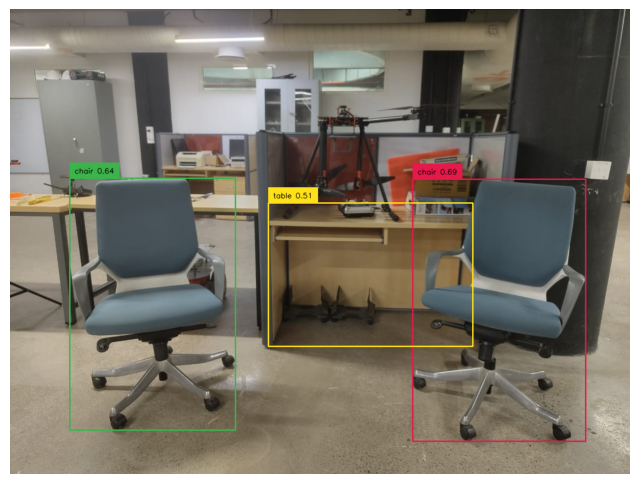

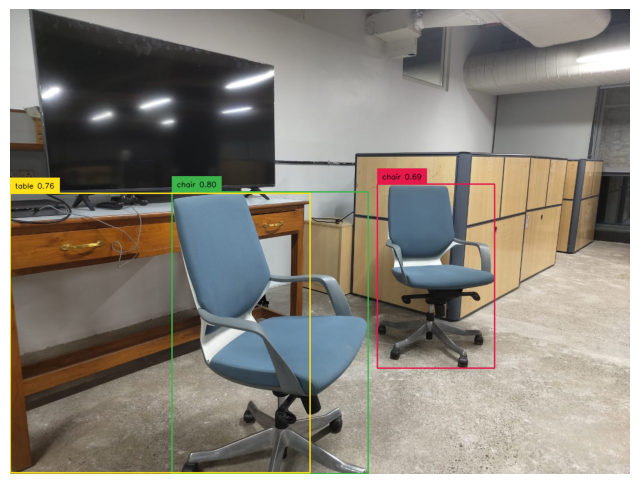

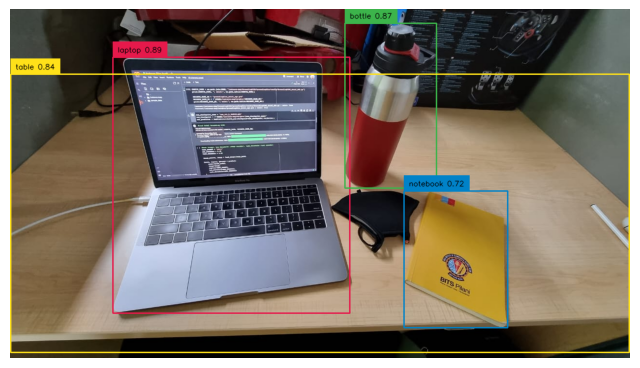

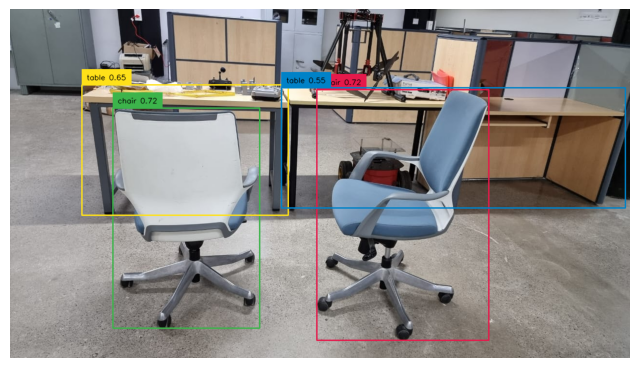

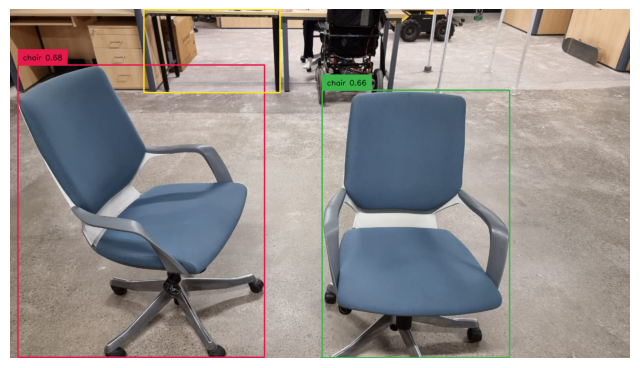

In [ ]:
BOX_TRESHOLD = 0.45
TEXT_TRESHOLD = 0.25

for img_id, img_data in img_dict.items():
    img_path = img_data['img_path']

    TEXT_PROMPT = img_dict[img_id]['ram_tags']
    image_source, image = load_image(img_path)

    # Get DINO Bounding Boxes
    boxes, logits, phrases = predict(
        model=GDINO_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # Get SAM Masks
    sam_image = cv2.imread(img_path)
    sam_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segmented_frame_masks = segment(sam_image, sam_predictor, boxes=boxes)

    num_objs = boxes.shape[0]
    objs = {}

    for j in range(num_objs):
      img_data['objs'][j] = {'bbox': boxes[j].cpu().numpy(),
                             'phrase' : phrases[j],
                             'prob' : logits[j].item(),
                             'mask' : segmented_frame_masks[j].cpu().squeeze().numpy(),
                             'clip_embed' : None,
                             'dino_embed' : None}


    # annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    # %matplotlib inline
    # sv.plot_image(annotated_frame, (8, 8))

In [ ]:
def display_masks(segmented_frame_masks, annotated_frame):
  #Display Mask
  num_images = segmented_frame_masks.shape[0]
  for i in range(num_images):
      # Get the ith image tensor
      image_tensor = segmented_frame_masks[i, 0]

      # Convert the tensor to a numpy array and squeeze
      image_np = image_tensor.cpu().numpy().squeeze()

      # Plot the image
      plt.imshow(image_np, cmap='gray')  #Graysale
      plt.title(f"Segmented Image {i + 1}")
      plt.axis('off')
      plt.show()

  # For Annotation (segmented_frame_masks[0][0]--> 1st, segmented_frame_masks[1][0] --> 2nd.....)
  annotated_frame_with_mask = draw_mask(segmented_frame_masks[1][0], annotated_frame)
  Image.fromarray(annotated_frame_with_mask)

In [ ]:
def crop_image(image, bounding_box):
    height, width = image.shape[:2]

    x, y, w, h = bounding_box
    xmin = int((x - w/2).item() * width)
    ymin = int((y - h/2).item() * height)
    xmax = int((x + w/2).item() * width)
    ymax = int((y + h/2).item() * height)
    cropped_image = image[ymin:ymax, xmin:xmax]

    return cropped_image

def resize_and_pad(image, desired_size=256):
    old_size = image.shape[:2]  # old_size is in (height, width) format

    # find the larger dimension of the image
    max_dim = max(old_size)
    ratio = float(desired_size) / max_dim
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))

    # compute the deltas for padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # create a border around the image
    color = [0, 0, 0]  # black padding
    new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_img

In [ ]:
# Embeddings for Clip and DINO

# DinoV2 Feature Extraction

_DINO_V2_MODELS = Literal["dinov2_vits14", "dinov2_vitb14", "dinov2_vitl14", "dinov2_vitg14"]
_DINO_FACETS = Literal["query", "key", "value", "token"]

class DinoV2ExtractFeatures: # ... (Code for the DinoV2ExtractFeatures class)
    """
        Extract features from an intermediate layer in Dino-v2
    """
    def __init__(self, dino_model: _DINO_V2_MODELS, layer: int,
                facet: _DINO_FACETS="token", use_cls=False,
                norm_descs=True, device: str = "cpu") -> None:
        """
            Parameters:
            - dino_model:   The DINO-v2 model to use
            - layer:        The layer to extract features from
            - facet:    "query", "key", or "value" for the attention
                        facets. "token" for the output of the layer.
            - use_cls:  If True, the CLS token (first item) is also
                        included in the returned list of descriptors.
                        Otherwise, only patch descriptors are used.
            - norm_descs:   If True, the descriptors are normalized
            - device:   PyTorch device to use
        """
        self.vit_type: str = dino_model
        self.dino_model: nn.Module = torch.hub.load(
                'facebookresearch/dinov2', dino_model)
        self.device = torch.device(device)
        self.dino_model = self.dino_model.eval().to(self.device)
        self.layer: int = layer
        self.facet = facet
        if self.facet == "token":
            self.fh_handle = self.dino_model.blocks[self.layer].\
                    register_forward_hook(
                            self._generate_forward_hook())
        else:
            self.fh_handle = self.dino_model.blocks[self.layer].\
                    attn.qkv.register_forward_hook(
                            self._generate_forward_hook())
        self.use_cls = use_cls
        self.norm_descs = norm_descs
        # Hook data
        self._hook_out = None

    def _generate_forward_hook(self):
        def _forward_hook(module, inputs, output):
            self._hook_out = output
        return _forward_hook

    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        """
            Parameters:
            - img:   The input image
        """
        with torch.no_grad():
            res = self.dino_model(img)
            if self.use_cls:
                res = self._hook_out
            else:
                res = self._hook_out[:, 1:, ...]
            if self.facet in ["query", "key", "value"]:
                d_len = res.shape[2] // 3
                if self.facet == "query":
                    res = res[:, :, :d_len]
                elif self.facet == "key":
                    res = res[:, :, d_len:2*d_len]
                else:
                    res = res[:, :, 2*d_len:]
        if self.norm_descs:
            res = F.normalize(res, dim=-1)
        self._hook_out = None   # Reset the hook
        return res

    def __del__(self):
        self.fh_handle.remove()

In [ ]:
# CLIP Model Loading and Preprocessing
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

# Preprocess function for input images
preprocess_fn_clip = Compose([
    Resize((224, 224)),
    CenterCrop((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dino_model_type="dinov2_vitb14"
layer=11
facet="key"
dino = DinoV2ExtractFeatures(dino_model_type, layer, facet, device="cuda:0")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
# Combined Function for Calculating Embeddings

def get_dino_clip_embeddings(cropped_img):
    # Load and preprocess the image for DinoV2
    # img = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR)
    img = resize_and_pad(cropped_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img.shape
    # print(img.shape)

    preprocess_dino = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop([(h // 14) * 14, (w // 14) * 14]),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    h_new, w_new = (h // 14) * 14, (w // 14) * 14
    img_tensor = preprocess_dino(img)[None, ...].cuda()

    # Calculate DinoV2 embeddings
    with torch.no_grad():
        dino_features = dino(img_tensor)

    # Load and preprocess the image for CLIP
    # image_clip = Image.open(image_path).convert("RGB")
    image_clip = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    input_clip = preprocess_fn_clip(image_clip).unsqueeze(0).to(device)

    # Calculate CLIP embeddings
    with torch.no_grad():
        clip_features = model_clip.encode_image(input_clip)

    return dino_features, clip_features

In [ ]:
for img_id, img_data in img_dict.items():
  img_path = img_data['img_path']
  img = cv2.imread(img_path)

  for obj_id, obj_data in img_data['objs'].items():
    cropped_img = crop_image(img, obj_data['bbox'])
    dino_features, clip_features = get_dino_clip_embeddings(cropped_img)

    clip_features = clip_features.cpu().squeeze().numpy()
    dino_features = dino_features.cpu().squeeze().numpy()

    obj_data['clip_embed'] = clip_features
    obj_data['dino_embed'] = dino_features
    # print("DinoV2 features shape:", dino_features.shape)
    # print("CLIP features shape:", clip_features.shape)

In [ ]:
img_dict[3]

{'img_path': '/content/test/3.jpeg',
 'ram_tags': 'chair . table',
 'objs': {0: {'bbox': array([0.21182686, 0.5796141 , 0.39765567, 0.8374812 ], dtype=float32),
   'phrase': 'chair',
   'prob': 0.6811674237251282,
   'mask': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   'clip_embed': None,
   'dino_embed': None},
  1: {'bbox': array([0.6548711 , 0.61567205, 0.3019533 , 0.76600796], dtype=float32),
   'phrase': 'chair',
   'prob': 0.6589716672897339,
   'mask': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, Fal

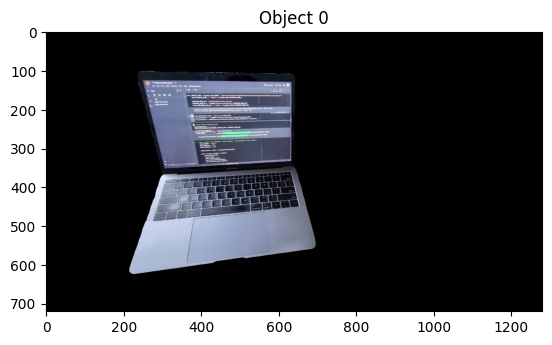

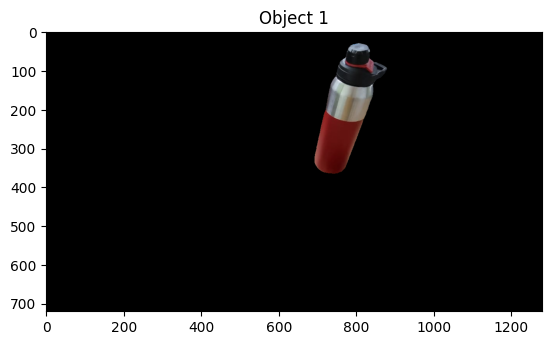

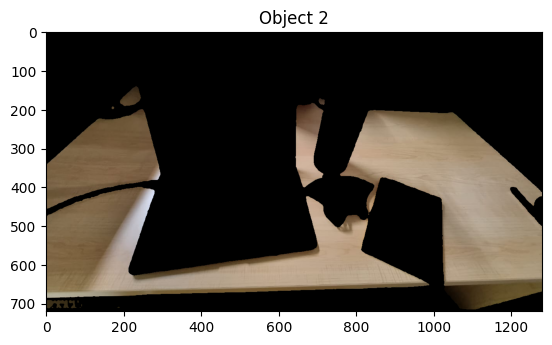

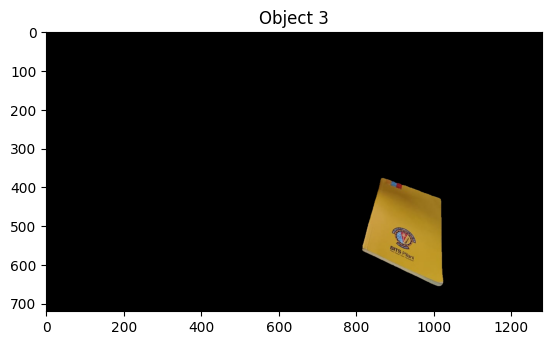

In [ ]:
#Code to visualize separate masks for a single image

img_id = 1

# Load the image
img_path = img_dict[img_id]['img_path']
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Get the object data for the image
objs = img_dict[img_id]['objs']

# Loop through each object in the image
for obj_index, obj_data in objs.items():
    # Get the mask for the object
    mask = obj_data['mask']

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Apply the mask to the image. This assumes your mask is binary (0s and 1s).
    # If it isn't, you may need to adjust this step accordingly.
    masked_image = img * np.expand_dims(mask, axis=2)

    # Display the masked image
    plt.figure()
    plt.imshow(masked_image)
    plt.title(f"Object {obj_index}")
    plt.show()


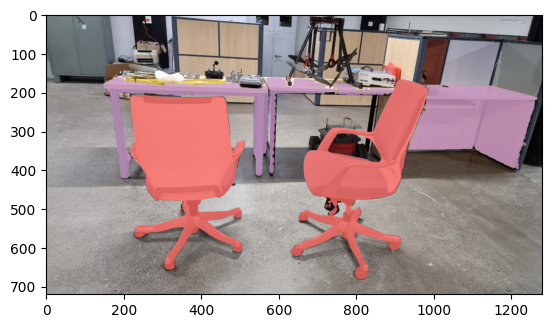

In [ ]:
#Code to draw the segmentation mask on the image

from torchvision.utils import draw_segmentation_masks

img_id = 2

# Load the image
img_path = img_dict[img_id]['img_path']
img = Image.open(img_path)  # Load with PIL to avoid needing to convert color spaces

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img)
img_tensor = (img_tensor * 255).byte()

# List of phrases and corresponding colors
req_tags = ['chair', 'laptop', 'bottle', 'notebook', 'table', 'monitor', 'printer']
colors = [
    (255, 105, 97),  # Pastel Red
    (255, 179, 71),  # Pastel Orange
    (253, 253, 150),  # Pastel Yellow
    (119, 221, 119),  # Pastel Green
    (203, 153, 201),  # Pastel Purple
    (174, 198, 207),  # Pastel Blue
    (255, 209, 220),  # Pastel Pink
]

masks = []
mask_colors = []

objs = img_dict[img_id]['objs']

for obj_index, obj_data in objs.items():
    mask = obj_data['mask']

    phrase = obj_data['phrase']

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Add the mask to the list of masks
    masks.append(mask)
    #Cheeck the color for the mask and add it to the list
    color = colors[req_tags.index(phrase)]
    mask_colors.append(color)

# Convert the masks to a boolean tensor
masks_tensor = torch.tensor(masks, dtype=torch.bool)

# Draw all masks on the image
result = draw_segmentation_masks(img_tensor, masks_tensor, colors=mask_colors)

# Convert the result tensor back to a PIL image, transpose the dimensions back to H,W,C for PIL
result_img = Image.fromarray(result.permute(1, 2, 0).byte().cpu().numpy())

# Display the image with all masks
plt.imshow(result_img)
plt.show()
